In [1]:
#Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Measurement Data Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get a list of column names and types
inspector = inspect(engine)

m_columns = inspector.get_columns('Measurement')
print("Measurement")
for c in m_columns:
    print(c['name'], c["type"])

s_columns = inspector.get_columns('Station')
print("Station")
for c in s_columns:
    print(c['name'], c["type"])


Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# View of Measurement Data
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
# View of Station Data
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [13]:
# Calculate the date 1 year ago from the last data point in the database
# Last Date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last date is: {last_date[0]}")

last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"Date one year ago is: {last_year_date}")

Last date is: 2017-08-23
Date one year ago is: 2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
p_scores = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date).\
order_by(Measurement.date >= last_year_date).all()
p_scores [: 5]

[('2010-01-01', 0.08),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-06', None)]

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precp_df = pd.DataFrame(p_scores, columns=['date', 'precipitation']).dropna()

#Set the index
precp_df.set_index('date',inplace=True)
precp_df = precp_df.sort_index()

precp_df.head()

,precipitation
date,
2010-01-01,0.08
2010-01-01,0.14
2010-01-01,0.21
2010-01-01,0.15
2010-01-01,0.15


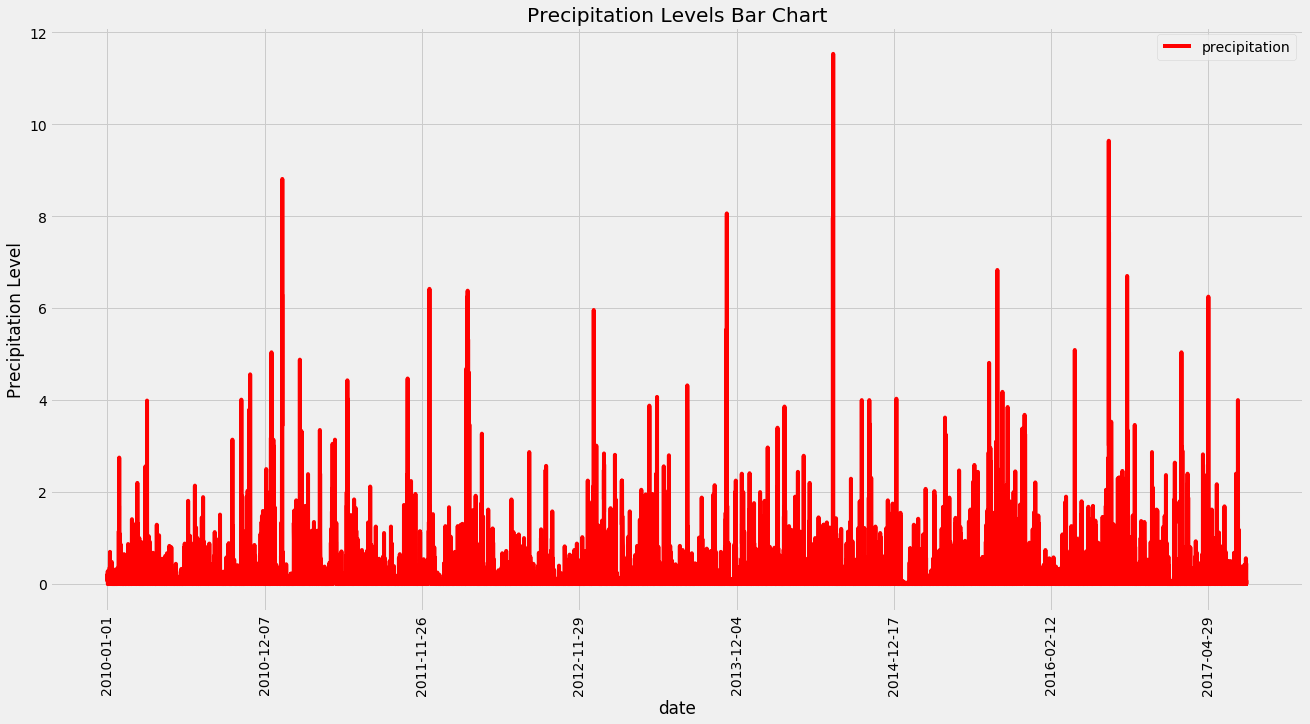

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
plot = precp_df.plot(rot=90, color="r", figsize=(20,10))
plot.set_title("Precipitation Levels Bar Chart")
plot.set_ylabel("Precipitation Level")

#Save image
plt.savefig("./images/precipitation")

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precp_df.describe()

,precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


Station Data Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).group_by(Station.station).count()
station_count

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.date)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()

active_stations [: 10]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id (most active station) from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [Measurement.station, 
       func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs)]

stats = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()

stats_df = pd.DataFrame(stats, columns=['Station', 'Max_Temp', 'Min_Temp', 'Mean_Temp'])
stats_df

,Station,Max_Temp,Min_Temp,Mean_Temp
0,USC00519281,85.0,54.0,71.663781


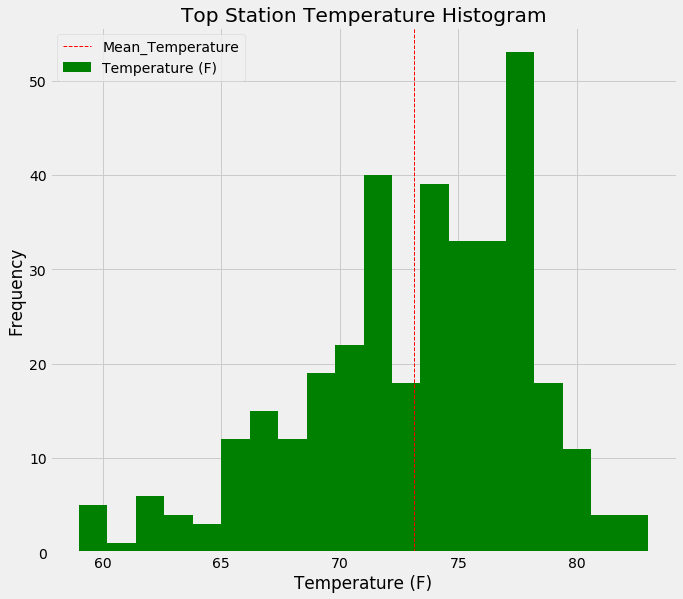

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [Measurement.station,
       Measurement.tobs]

high_temp = session.query(*sel).\
    filter(Measurement.date >= last_year_date).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.date).\
    order_by(Measurement.date.asc()).all()
    
#Setup to dataframe
high_temp_df = pd.DataFrame(high_temp, columns=['Date', 'Temp'])
high_temp_df.set_index('Date', inplace=True)
    
#Histogram plot of temperatures
plt.figure(figsize=(10,9))
plt.hist(high_temp_df['Temp'], 20, density=False, label="Temperature (F)", color="g")

#Setup labels
plt.axvline(high_temp_df['Temp'].mean(), color='r', linestyle='dashed', linewidth=1, label="Mean_Temperature")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Top Station Temperature Histogram")


#Save image
plt.savefig("./images/station-histogram")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
